In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*The 'nopython' keyword.*")
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
import pandas as pd
import geopandas as gpd
import libpysal as lps
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from libpysal.weights import KNN, lag_spatial
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE, ADASYN
import xgboost as xgb
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE, ADASYN
import xgboost as xgb
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import statsmodels.api as sm
%matplotlib inline

C:\Users\eilid\anaconda3\lib\site-packages\libpysal\cg\alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
C:\Users\eilid\anaconda3\lib\site-packages\libpysal\cg\alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
C:\Users\eilid\anaconda3\lib\site-packages\libpysal\cg\alpha_shapes.py:199: N

In [3]:
df = pd.read_csv("C:\\Users\eilid\\Desktop\\MSc AI Project\\example_data_for_eilidh\\geocodedf.csv")

# ESDA

In [4]:
# Plotting distribution of businesses by Access Rank
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, y='DESCRIP', x='access_domain_rank', palette='viridis')
plt.xlabel('Access Domain Rank')
plt.ylabel('Type of Business')
plt.title('Types of Businesses per Access Rank')
plt.show()

In [5]:
# Plotting distribution of businesses by Deprivation Rank
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, y='DESCRIP', x='percentile', palette='viridis')
plt.xlabel('Access Domain Rank')
plt.ylabel('Type of Business')
plt.title('Types of Businesses per Access Rank')
plt.show()

In [6]:
# Creating a geodataframe from the longitude and latitude columns
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
crs = 'EPSG:4326' #crs = coordinate reference system (API)
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [7]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9599 entries, 0 to 9598
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   postcode                9599 non-null   object  
 1   percentile              9599 non-null   float64 
 2   income_domain_rank      9599 non-null   float64 
 3   employment_domain_rank  9599 non-null   float64 
 4   education_domain_rank   9599 non-null   float64 
 5   health_domain_rank      9599 non-null   float64 
 6   access_domain_rank      9599 non-null   float64 
 7   crime_domain_rank       9599 non-null   float64 
 8   housing_domain_rank     9599 non-null   float64 
 9   working_age_population  9599 non-null   float64 
 10  urname                  9599 non-null   float64 
 11  council_area            9599 non-null   float64 
 12  total_population        9599 non-null   float64 
 13  income_count            9599 non-null   float64 
 14  employment_count

In [8]:
gdf.groupby('DESCRIP')['access_domain_rank'].describe()

count      mean       std       min       25%  \
DESCRIP                                                                         
Accommodation                   491.0  0.679406  0.222339  0.056330  0.578127   
Advertising                     115.0  0.655724  0.209187  0.073408  0.549963   
Animal Services                   9.0  0.294682  0.246258  0.056330  0.060974   
Bank                             29.0  0.721297  0.188678  0.272060  0.631461   
Burial Services                  21.0  0.686927  0.243741  0.073408  0.619476   
Childcare                        11.0  0.663371  0.268401  0.060974  0.574831   
Church & Hall                   116.0  0.704075  0.248418  0.060974  0.578127   
Commercial property             190.0  0.590825  0.269939  0.056330  0.430562   
Community                        47.0  0.651583  0.271294  0.060974  0.529288   
Construction                     69.0  0.649564  0.237982  0.113858  0.500974   
Culture                          15.0  0.693064  0.206618  0.073408  0.677678   
Emergency Services               20.0  0.561880  0.246187  0.073408  0.411723   
Energy & Waste                   19.0  0.290684  0.263484  0.056330  0.094382   
Entertainment                    32.0  0.739050  0.123088  0.500974  0.657978   
Factory & Industrial            801.0  0.423311  0.256039  0.038202  0.272060   
Healthcare                      150.0  0.701517  0.229847  0.060974  0.556704   
Office                         2811.0  0.637241  0.250192  0.060974  0.500974   
Other                            84.0  0.646891  0.266666  0.094382  0.529026   
Pub                             153.0  0.705588  0.189382  0.094382  0.634906   
Public Services                  19.0  0.697000  0.213645  0.237303  0.662547   
Restaurant                      295.0  0.699893  0.193917  0.060974  0.578127   
Retail                         1803.0  0.746801  0.196628  0.056330  0.662622   
School                          160.0  0.599478  0.278765  0.056330  0.391011   
Sports & Recreation             221.0  0.535246  0.254751  0.056330  0.293034   
Transport                        12.0  0.307990  0.163790  0.056330  0.272060   
Vehicle Storage & Maintenance   891.0  0.646268  0.253643  0.038502  0.500974   
Warehouse                       925.0  0.505216  0.244513  0.056330  0.272060   
Yard                             90.0  0.390267  0.252678  0.060974  0.118052   

                                    50%       75%       max  
DESCRIP                                                      
Accommodation                  0.739625  0.855431  1.000000  
Advertising                    0.653933  0.827491  0.991011  
Animal Services                0.281798  0.465918  0.634906  
Bank                           0.749513  0.898876  0.980225  
Burial Services                0.785169  0.846442  0.939925  
Childcare                      0.740225  0.824195  0.934831  
Church & Hall                  0.749513  0.912509  0.999700  
Commercial property            0.655955  0.811423  0.998502  
Community                      0.717453  0.857678  0.985918  
Construction                   0.673258  0.886292  0.998502  
Culture                        0.749513  0.796255  0.900075  
Emergency Services             0.618427  0.752959  0.912509  
Energy & Waste                 0.118951  0.434232  0.906517  
Entertainment                  0.744869  0.796255  0.975880  
Factory & Industrial           0.430562  0.528240  0.998502  
Healthcare                     0.744869  0.915655  0.998502  
Office                         0.657978  0.900075  1.000000  
Other                          0.713558  0.855431  0.998502  
Pub                            0.749513  0.855431  1.000000  
Public Services                0.744869  0.844794  0.972135  
Restaurant                     0.716105  0.898876  1.000000  
Retail                         0.749513  0.900075  1.000000  
School                         0.653483  0.800075  1.000000  
Sports & Recreation            0.578127  0.673258  

In [9]:
gdf.groupby('DESCRIP')['urname'].describe()

count      mean       std  min  25%  50%  75%  \
DESCRIP                                                                         
Accommodation                   491.0  0.963340  0.188117  0.0  1.0  1.0  1.0   
Advertising                     115.0  0.991304  0.093250  0.0  1.0  1.0  1.0   
Animal Services                   9.0  0.666667  0.500000  0.0  0.0  1.0  1.0   
Bank                             29.0  0.931034  0.257881  0.0  1.0  1.0  1.0   
Burial Services                  21.0  0.952381  0.218218  0.0  1.0  1.0  1.0   
Childcare                        11.0  0.818182  0.404520  0.0  1.0  1.0  1.0   
Church & Hall                   116.0  0.956897  0.203971  0.0  1.0  1.0  1.0   
Commercial property             190.0  0.921053  0.270369  0.0  1.0  1.0  1.0   
Community                        47.0  0.936170  0.247092  0.0  1.0  1.0  1.0   
Construction                     69.0  0.985507  0.120386  0.0  1.0  1.0  1.0   
Culture                          15.0  0.933333  0.258199  0.0  1.0  1.0  1.0   
Emergency Services               20.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
Energy & Waste                   19.0  0.947368  0.229416  0.0  1.0  1.0  1.0   
Entertainment                    32.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
Factory & Industrial            801.0  0.973783  0.159881  0.0  1.0  1.0  1.0   
Healthcare                      150.0  0.946667  0.225450  0.0  1.0  1.0  1.0   
Office                         2811.0  0.991462  0.092022  0.0  1.0  1.0  1.0   
Other                            84.0  0.988095  0.109109  0.0  1.0  1.0  1.0   
Pub                             153.0  0.973856  0.160087  0.0  1.0  1.0  1.0   
Public Services                  19.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
Restaurant                      295.0  0.979661  0.141397  0.0  1.0  1.0  1.0   
Retail                         1803.0  0.980033  0.139925  0.0  1.0  1.0  1.0   
School                          160.0  0.906250  0.292396  0.0  1.0  1.0  1.0   
Sports & Recreation             221.0  0.932127  0.252099  0.0  1.0  1.0  1.0   
Transport                        12.0  0.916667  0.288675  0.0  1.0  1.0  1.0   
Vehicle Storage & Maintenance   891.0  0.976431  0.151787  0.0  1.0  1.0  1.0   
Warehouse                       925.0  0.991351  0.092645  0.0  1.0  1.0  1.0   
Yard                             90.0  0.988889  0.105409  0.0  1.0  1.0  1.0   

                               max  
DESCRIP                             
Accommodation                  1.0  
Advertising                    1.0  
Animal Services                1.0  
Bank                           1.0  
Burial Services                1.0  
Childcare                      1.0  
Church & Hall                  1.0  
Commercial property            1.0  
Community                      1.0  
Construction                   1.0  
Culture                        1.0  
Emergency Services             1.0  
Energy & Waste                 1.0  
Entertainment                  1.0  
Factory & Industrial           1.0  
Healthcare                     1.0  
Office                         1.0  
Other                          1.0  
Pub                            1.0  
Public Services                1.0  
Restaurant                     1.0  
Retail                         1.0  
School                         1.0  
Sports & Recreation            1.0  
Transport                      1.0  
Vehicle Storage & Maintenance  1.0  
Warehouse                      1.0  
Yard                           1.0

In [10]:
#Postcodes by Deprivation Ranking
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={'aspect':'equal'}) 
gdf.plot(column='percentile', scheme='Quantiles', k=5, cmap='viridis', legend=True, ax=ax)
plt.title('Deprivation Ranking by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

In [11]:
#Postcodes by Access Ranking
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={'aspect':'equal'}) 
gdf.plot(column='access_domain_rank', scheme='Quantiles', k=5, cmap='viridis', legend=True, ax=ax)
plt.title('Access Ranking by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

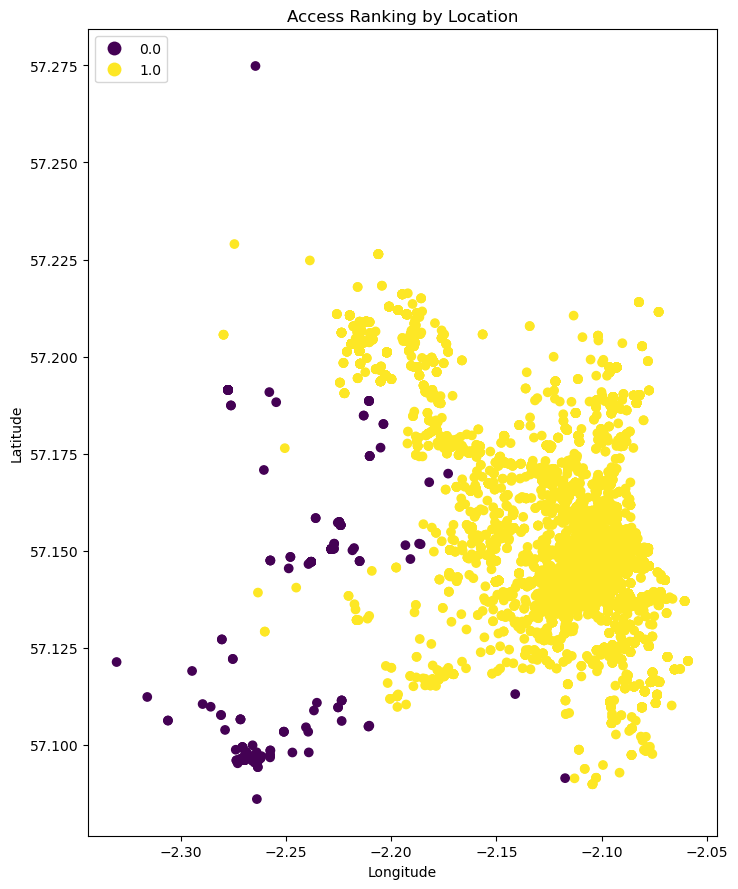

In [12]:
# Urban vs Rural Postcodes
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={'aspect':'equal'})
gdf.plot(column='urname', categorical=True, legend=True, ax=ax, legend_kwds={'loc': 'upper left'}, cmap='viridis')
plt.title('Access Ranking by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

In [13]:
# Plotting the distribution of businesses
categories = gdf['DESCRIP'].unique()
num_categories = len(categories)
cmap = ListedColormap(plt.cm.tab20b.colors[:num_categories] + plt.cm.tab20c.colors[:num_categories])
fig, ax = plt.subplots(figsize=(15, 15))
gdf.plot(column='DESCRIP', cmap=cmap, categorical=True, legend=True, ax=ax, legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left'})
plt.title('Distribution of Businesses')
plt.show()

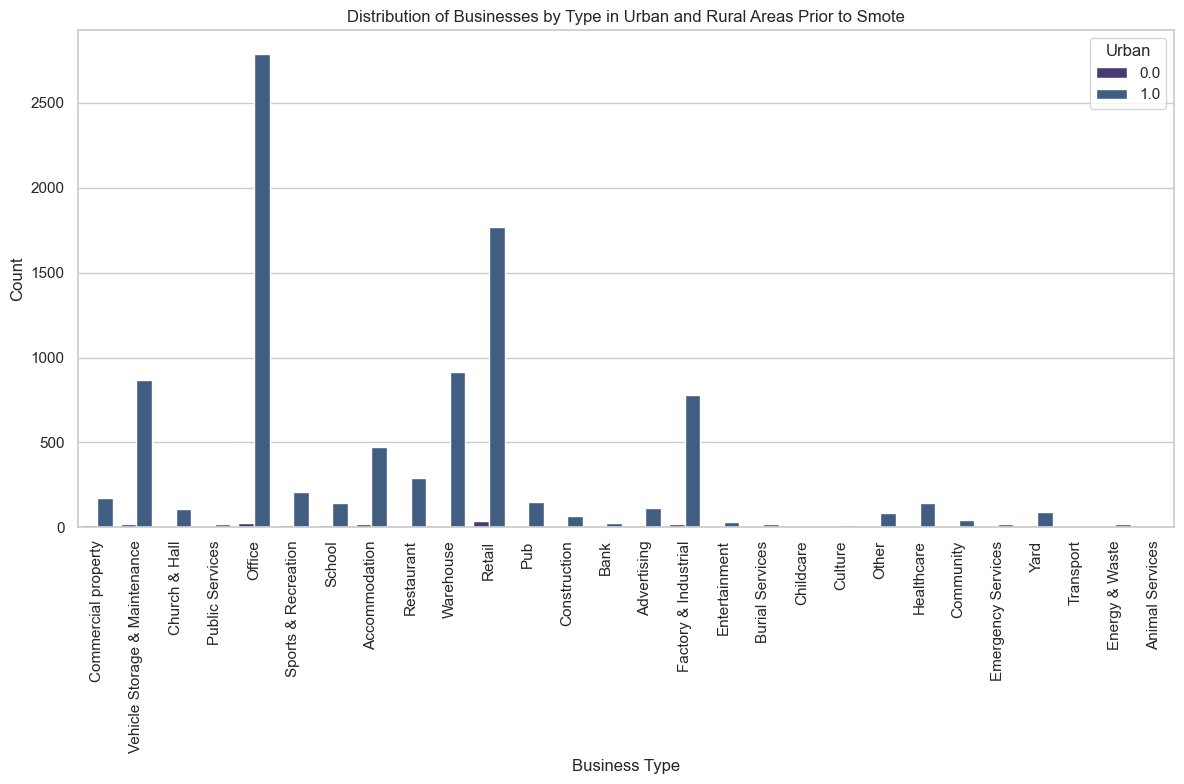

In [14]:
#Distribution of Businesses in urban and rural areas
sns.set(style="whitegrid")
sns.set_palette("viridis")
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='DESCRIP', hue='urname', dodge=True)
plt.xticks(rotation=90)
plt.title('Distribution of Businesses by Type in Urban and Rural Areas Prior to Smote')
plt.xlabel('Business Type')
plt.ylabel('Count')
plt.legend(title='Urban')
plt.tight_layout()

plt.show()

In [15]:
#smote = SMOTE(random_state = 42)
#X, y = smote.fit_resample(df[['percentile', 'access_domain_rank']], df['DESCRIP'])
#df1_smote = pd.DataFrame(X, columns = ['percentile', 'access_domain_rank'])
#df1_smote['DESCRIP'] = y

In [16]:
#sns.set(style="whitegrid")
#sns.set_palette("viridis")
#plt.figure(figsize=(12, 8))
#sns.countplot(data=df1_smote, x='DESCRIP', hue='percentile', dodge=True)
#plt.xticks(rotation=90)
#plt.title('Distribution of Businesses by Type in Urban and Rural Areas Prior to Smote')
#plt.xlabel('Business Type')
#plt.ylabel('Count')
#plt.legend(title='Urban')
#plt.tight_layout()

#plt.show()

# Geospatital Weights Matrix K determination

For k = 2, Silhouette Score: 0.6631
For k = 3, Silhouette Score: 0.4570
For k = 4, Silhouette Score: 0.4624
For k = 5, Silhouette Score: 0.4926
For k = 6, Silhouette Score: 0.4366
For k = 7, Silhouette Score: 0.4464
For k = 8, Silhouette Score: 0.4502
For k = 9, Silhouette Score: 0.4081
For k = 10, Silhouette Score: 0.4228
For k = 11, Silhouette Score: 0.4147
For k = 12, Silhouette Score: 0.4120
For k = 13, Silhouette Score: 0.3925
For k = 14, Silhouette Score: 0.3926
For k = 15, Silhouette Score: 0.3954
For k = 16, Silhouette Score: 0.3915
For k = 17, Silhouette Score: 0.3885
For k = 18, Silhouette Score: 0.3995
For k = 19, Silhouette Score: 0.3845
For k = 20, Silhouette Score: 0.3886


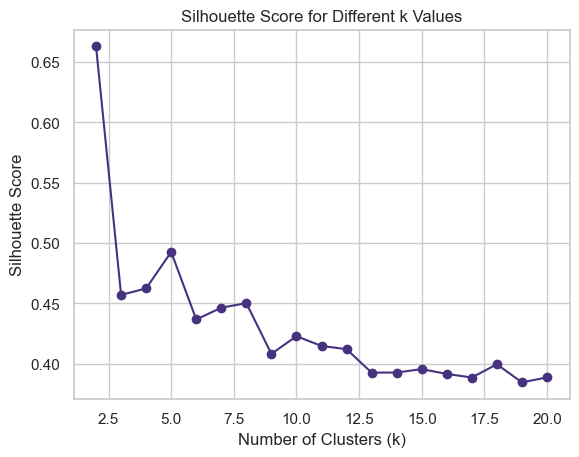

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Define a range of k values you want to test
k_values = range(2, 21)  # You can adjust the range as needed
coordinates = gdf[['longitude', 'latitude']].values
silhouette_scores = []

# Calculate silhouette scores for different k values
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(coordinates)
    silhouette_avg = silhouette_score(coordinates, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For k = {k}, Silhouette Score: {silhouette_avg:.4f}")

# Plot the silhouette scores against k values
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k Values')
plt.show()

In [18]:
#Creating a weights matrix with k nearest neighbours approach. 
coordinates = gdf[['longitude', 'latitude']].values
K = 19
wq = KNN.from_array(coordinates, k=K)
wq.transform = 'r'

C:\Users\eilid\anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 22 disconnected components.
  warnings.warn(message)


# DBSCAN Clustering Parameter Determination

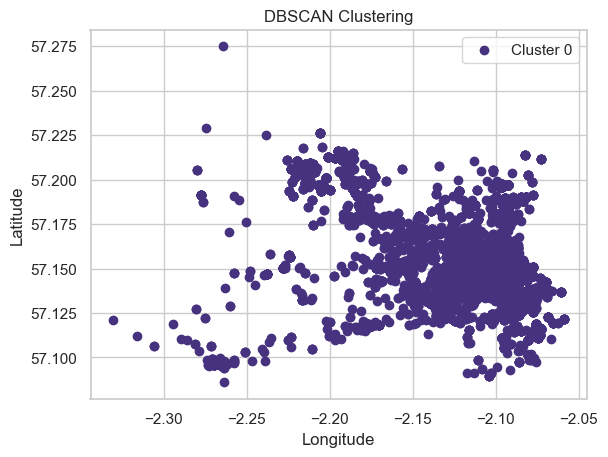

In [19]:
dbscan = DBSCAN(eps=0.1, min_samples=5)
labels = dbscan.fit_predict(coordinates)
unique_labels = set(labels)
for label in unique_labels:
    if label == -1:  # Noise points
        plt.scatter(coordinates[labels == label, 0], coordinates[labels == label, 1], label='Noise', marker='x')
    else:
        plt.scatter(coordinates[labels == label, 0], coordinates[labels == label, 1], label=f'Cluster {label}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering')
plt.legend()
plt.show()


In [20]:
# Create a spatial weights matrix using KNN
K = 12  # Set the number of neighbors you want
w = KNN.from_array(gdf, k=K)

# Calculate spatial lags for 'percentile' and 'access_domain_rank'
gdf['percentile_lag'] = lag_spatial(w, gdf['percentile'])
gdf['access_domain_rank_lag'] = lag_spatial(w, gdf['access_domain_rank'])

# Optional: Convert categorical variable 'DESCRIP' to numerical format using one-hot encoding
encoded_df = pd.get_dummies(gdf, columns=['DESCRIP'])

# Extract the attribute data into a 2D array for input to the SAR model
attributes = encoded_df[['percentile', 'access_domain_rank', 'percentile_lag', 'access_domain_rank_lag']].values

# Build your SAR model using your preferred machine learning library
# (e.g., scikit-learn, statsmodels, etc.)
# Example using statsmodels:
import statsmodels.api as sm

X = attributes  # Features
y = gdf['access_domain_rank']  # Target variable

model = sm.OLS(y, X)
results = model.fit()

# Print the model summary
print(results.summary())

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\eilid\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\eilid\AppData\Local\Temp\ipykernel_10316\390904044.py", line 3, in <module>
    w = KNN.from_array(gdf, k=K)
  File "C:\Users\eilid\anaconda3\lib\site-packages\libpysal\weights\distance.py", line 271, in from_array
    return cls(array, *args, **kwargs)
  File "C:\Users\eilid\anaconda3\lib\site-packages\libpysal\weights\distance.py", line 122, in __init__
    self.kdtree = KDTree(data, radius=radius, distance_metric=distance_metric)
  File "C:\Users\eilid\anaconda3\lib\site-packages\libpysal\cg\kdtree.py", line 54, in KDTree
    return scipy.spatial.cKDTree(data, leafsize)
  File "_ckdtree.pyx", line 555, in scipy.spatial._ckdtree.cKDTree.__init__
  File "C:\Users\eilid\anaconda3\lib\site-packages\pandas\core\generic.py", line 2070, in __array__
    return np.asarray(self._v

### Spatial Autocorrelation - Local Moran's I Analysis

In [ ]:
import geopandas as gpd
from libpysal.weights import KNN
from esda.moran import Moran_Local
import matplotlib.pyplot as plt

# Assuming 'gdf' is your GeoDataFrame

# Step 2: Combine longitude and latitude into a 2D array for input to KNN
coordinates = gdf[['longitude', 'latitude']].values

# Step 3: Calculate K-Nearest Neighbor Spatial Weights
K = 19  # Set the number of neighbors you want
wq = KNN.from_array(coordinates, k=K)

# Step 4: Extract the variable you want to analyze (e.g., 'percentile')
variable_array = gdf['access_domain_rank'].values

# Step 5: Perform Local Moran's I analysis
moran_loc = Moran_Local(variable_array, wq)

# Step 6: Access local Moran's I statistics and p-values
print("Local Moran's I:", moran_loc.Is)
print("Local p-values:", moran_loc.p_sim)

# Visualize local Moran's I significance map
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={'aspect':'equal'})
gdf.plot(column=moran_loc.p_sim, cmap='RdYlBu', legend=True, ax=ax)
plt.title("Local Moran's I - Significance")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

When interpreting these results, you're looking for areas with high local Moran's I values and low p-values. These indicate statistically significant spatial clusters. To visualize these results, you can create a map that highlights areas with significant positive or negative spatial autocorrelation patterns.

For example, you can modify the visualization part of the code to display areas with significant spatial patterns:

In [ ]:
# Visualize local Moran's I significance map
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={'aspect':'equal'})
gdf.plot(column=moran_loc.p_sim < 0.05, cmap='coolwarm', legend=True, ax=ax)
plt.title("Local Moran's I - Significance")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

### Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers

In [ ]:
import geopandas as gpd
from libpysal.weights import KNN
from esda.getisord import G_Local
import matplotlib.pyplot as plt

# Assuming 'gdf' is your GeoDataFrame

# Step 2: Combine longitude and latitude into a 2D array for input to KNN
coordinates = gdf[['longitude', 'latitude']].values

# Step 3: Calculate K-Nearest Neighbor Spatial Weights
K = 12  # Set the number of neighbors you want
wq = KNN.from_array(coordinates, k=K)

# Step 4: Extract the variable you want to analyze (e.g., 'percentile')
variable_array = gdf['access_domain_rank'].values

# Step 5: Perform Local Getis-Ord General G analysis
g_local = G_Local(variable_array, wq)

# Step 6: Access local Getis-Ord General G statistics and p-values
print("Local Getis-Ord G:", g_local.Gs)
print("Local p-values:", g_local.p_sim)

# Visualize local Getis-Ord General G significance map
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={'aspect':'equal'})
gdf.plot(column=g_local.p_sim < 0.05, cmap='coolwarm', legend=True, ax=ax)
plt.title("Local Getis-Ord General G - Significance")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

### Local Spatital Regression

Local Spatial Regression: Local spatial regression techniques, such as Local Moran's I Regression, allow you to explore how the relationship between variables varies across space. This can help you identify areas where the relationships differ within disconnected components.

In [ ]:
import geopandas as gpd
from libpysal.weights import KNN
from esda.moran import Moran_Local
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn's 'viridis' color palette
sns.set_palette("viridis")

# Assuming 'gdf' is your GeoDataFrame

# Step 2: Combine longitude and latitude into a 2D array for input to KNN
coordinates = gdf[['longitude', 'latitude']].values

# Step 3: Calculate K-Nearest Neighbor Spatial Weights
K = 12  # Set the number of neighbors you want
wq = KNN.from_array(coordinates, k=K)

# Step 4: Extract the numerical variable you want to analyze
numerical_variable = gdf['access_domain_rank']

# Step 5: Perform Local Moran's LISA analysis
lisa = Moran_Local(numerical_variable.values, w=wq)

# Visualize significant clusters on the map using the 'viridis' color scheme
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=sns.color_palette()[0])  # Use the first color from the palette
sig_cluster_mask = lisa.p_sim < 0.05  # Mask for significant clusters
gdf[sig_cluster_mask].plot(ax=ax, color=sns.color_palette()[5])  # Use the third color from the palette
plt.title("Local Moran's LISA Clusters")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


# Machine Learning Preprocessing 

In [ ]:
#Creating the geospatial weights matrix
# Combine longitude and latitude into a 2D array for input to KNN
coordinates = gdf[['longitude', 'latitude']].values

# Set K-Nearest Neighbor Spatial Weights
K = 19  # Set the number of neighbors you want
w = KNN.from_array(coordinates, k=K)

In [ ]:
# Calculate spatial lags for all the attributes
lag_columns = ['percentile', 'income_domain_rank', 'employment_domain_rank', 'education_domain_rank',
               'health_domain_rank', 'access_domain_rank', 'crime_domain_rank', 'housing_domain_rank',
               'working_age_population', 'urname', 'council_area', 'total_population', 'income_count',
               'employment_count', 'cif', 'alcohol', 'drug', 'smr', 'depress', 'lbwt', 'emerg',
               'attendance', 'attainment', 'no_qualifications', 'not_participating', 'university',
               'drive_petrol', 'drive_gp', 'drive_post', 'drive_primary', 'drive_retail', 'drive_secondary',
               'pt_gp', 'pt_post', 'pt_retail', 'broadband', 'crime_count', 'overcrowded_count',
               'nocentralheat_count']

for column in lag_columns:
    gdf[f'{column}_lag'] = lag_spatial(w, gdf[column])


In [ ]:
# Extract the attribute data into a feature matrix and target variable
X = gdf[lag_columns + [f'{column}_lag' for column in lag_columns]]
y = gdf['DESCRIP']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Resample the 'DESCRIP' class labels using ADASYN
adasyn = ADASYN(random_state=42)

X_resampled, y_resampled = adasyn.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['DESCRIP'] = y_resampled

In [ ]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.1, min_samples=5)  
cluster_labels = dbscan.fit_predict(coordinates)

# Add the cluster column to the GeoDataFrame
gdf['cluster'] = cluster_labels

 # Baseline with Spatial Weights

In [ ]:
##### Random Forest Classifier #####
# Encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

random_forest_predictions = random_forest_model.predict(X_test)
random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)
random_forest_precision = precision_score(y_test, random_forest_predictions, average='weighted', zero_division=1)
random_forest_recall = recall_score(y_test, random_forest_predictions, average='weighted', zero_division=1)
random_forest_f1 = f1_score(y_test, random_forest_predictions, average='weighted')

print("Random Forest Classifier Metrics:")
print(f"Accuracy: {random_forest_accuracy:.2f}")
print(f"Precision: {random_forest_precision:.2f}")
print(f"Recall: {random_forest_recall:.2f}")
print(f"F1-score: {random_forest_f1:.2f}")
print()

##### XGBoost Classifier #####
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions, average='weighted', zero_division=1)
xgb_recall = recall_score(y_test, xgb_predictions, average='weighted', zero_division=1)
xgb_f1 = f1_score(y_test, xgb_predictions, average='weighted')

print("Gradient Boosting Metrics:")
print(f"Accuracy: {gradient_boosting_accuracy:.2f}")
print(f"Precision: {gradient_boosting_precision:.2f}")
print(f"Recall: {gradient_boosting_recall:.2f}")
print(f"F1-score: {gradient_boosting_f1:.2f}")
print()

##### Decision Tree Classifier #####
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

decision_tree_predictions = decision_tree_model.predict(X_test)
decision_tree_accuracy = accuracy_score(y_test, decision_tree_predictions)
decision_tree_precision = precision_score(y_test, decision_tree_predictions, average='weighted', zero_division=1)
decision_tree_recall = recall_score(y_test, decision_tree_predictions, average='weighted', zero_division=1)
decision_tree_f1 = f1_score(y_test, decision_tree_predictions, average='weighted', zero_division=1)

print("Decision Tree Classifier Metrics:")
print(f"Accuracy: {decision_tree_accuracy:.2f}")
print(f"Precision: {decision_tree_precision:.2f}")
print(f"Recall: {decision_tree_recall:.2f}")
print(f"F1-score: {decision_tree_f1:.2f}")
print()

##### Support Vector Machine Classifier #####
svm_model = SVC()
svm_model.fit(X_train, y_train)

svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions, average='weighted', zero_division=1)
svm_recall = recall_score(y_test, svm_predictions, average='weighted', zero_division=1)
svm_f1 = f1_score(y_test, svm_predictions, average='weighted')

print("Support Vector Machine Classifier Metrics:")
print(f"Accuracy: {svm_accuracy:.2f}")
print(f"Precision: {svm_precision:.2f}")
print(f"Recall: {svm_recall:.2f}")
print(f"F1-score: {svm_f1:.2f}")
print()

# Baseline models with spatial weights and ADASYN

In [ ]:
# Resampling the train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_resampled.drop('DESCRIP', axis=1), df_resampled['DESCRIP'], test_size=0.2, random_state=42)

##### Random Forest Classifier #####
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

random_forest_predictions = random_forest_model.predict(X_test)
random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)
random_forest_precision = precision_score(y_test, random_forest_predictions, average='weighted', zero_division=1)
random_forest_recall = recall_score(y_test, random_forest_predictions, average='weighted', zero_division=1)
random_forest_f1 = f1_score(y_test, random_forest_predictions, average='weighted')

print("Random Forest Classifier Metrics:")
print(f"Accuracy: {random_forest_accuracy:.2f}")
print(f"Precision: {random_forest_precision:.2f}")
print(f"Recall: {random_forest_recall:.2f}")
print(f"F1-score: {random_forest_f1:.2f}")
print()

##### XGBoost Classifier #####
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions, average='weighted', zero_division=1)
xgb_recall = recall_score(y_test, xgb_predictions, average='weighted', zero_division=1)
xgb_f1 = f1_score(y_test, xgb_predictions, average='weighted')

print("Gradient Boosting Metrics:")
print(f"Accuracy: {gradient_boosting_accuracy:.2f}")
print(f"Precision: {gradient_boosting_precision:.2f}")
print(f"Recall: {gradient_boosting_recall:.2f}")
print(f"F1-score: {gradient_boosting_f1:.2f}")
print()

##### Decision Tree Classifier #####
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

decision_tree_predictions = decision_tree_model.predict(X_test)
decision_tree_accuracy = accuracy_score(y_test, decision_tree_predictions)
decision_tree_precision = precision_score(y_test, decision_tree_predictions, average='weighted', zero_division=1)
decision_tree_recall = recall_score(y_test, decision_tree_predictions, average='weighted', zero_division=1)
decision_tree_f1 = f1_score(y_test, decision_tree_predictions, average='weighted', zero_division=1)

print("Decision Tree Classifier Metrics:")
print(f"Accuracy: {decision_tree_accuracy:.2f}")
print(f"Precision: {decision_tree_precision:.2f}")
print(f"Recall: {decision_tree_recall:.2f}")
print(f"F1-score: {decision_tree_f1:.2f}")
print()

##### Support Vector Machine Classifier #####
svm_model = SVC()
svm_model.fit(X_train, y_train)

svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions, average='weighted', zero_division=1)
svm_recall = recall_score(y_test, svm_predictions, average='weighted', zero_division=1)
svm_f1 = f1_score(y_test, svm_predictions, average='weighted')

print("Support Vector Machine Classifier Metrics:")
print(f"Accuracy: {svm_accuracy:.2f}")
print(f"Precision: {svm_precision:.2f}")
print(f"Recall: {svm_recall:.2f}")
print(f"F1-score: {svm_f1:.2f}")
print()

# Ensemble Baseline + ADASYN + Spatital Weights Matrix

In [ ]:
ensemble_classifier = VotingClassifier(
    estimators=[
        ('Random Forest', random_forest_model),
        ('Gradient Boosting', gradient_boosting_model),
        ('Decision Tree', decision_tree_model),
        ('Support Vector Machine', svm_model)
    ],
    voting='hard'
)


ensemble_classifier.fit(X_train, y_train)
ensemble_predictions = ensemble_classifier.predict(X_test)

ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_precision = precision_score(y_test, ensemble_predictions, average='weighted')
ensemble_recall = recall_score(y_test, ensemble_predictions, average='weighted')
ensemble_f1 = f1_score(y_test, ensemble_predictions, average='weighted')

print("Ensemble Classifier Metrics:")
print(f"Accuracy: {ensemble_accuracy:.2f}")
print(f"Precision: {ensemble_precision:.2f}")
print(f"Recall: {ensemble_recall:.2f}")
print(f"F1-score: {ensemble_f1:.2f}")

# Baseline & Weights Matrix & DBSCAN Clustering 

In [ ]:
# Include the cluster variable in the feature matrix
lag_columns_with_lags = lag_columns + [f'{column}_lag' for column in lag_columns]
X = gdf[lag_columns_with_lags + ['cluster']]  # Add 'cluster' column
y = gdf['DESCRIP']

# Resample X any Y
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['DESCRIP'] = y_resampled

# Splitting the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_resampled.drop('DESCRIP', axis=1), df_resampled['DESCRIP'], test_size=0.2, random_state=42)

##### Random Forest Classifier #####
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

random_forest_predictions = random_forest_model.predict(X_test)
random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)
random_forest_precision = precision_score(y_test, random_forest_predictions, average='weighted', zero_division=1)
random_forest_recall = recall_score(y_test, random_forest_predictions, average='weighted', zero_division=1)
random_forest_f1 = f1_score(y_test, random_forest_predictions, average='weighted')

print("Random Forest Classifier Metrics:")
print(f"Accuracy: {random_forest_accuracy:.2f}")
print(f"Precision: {random_forest_precision:.2f}")
print(f"Recall: {random_forest_recall:.2f}")
print(f"F1-score: {random_forest_f1:.2f}")
print()

##### XGBoost Classifier #####
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions, average='weighted', zero_division=1)
xgb_recall = recall_score(y_test, xgb_predictions, average='weighted', zero_division=1)
xgb_f1 = f1_score(y_test, xgb_predictions, average='weighted')

print("Gradient Boosting Metrics:")
print(f"Accuracy: {gradient_boosting_accuracy:.2f}")
print(f"Precision: {gradient_boosting_precision:.2f}")
print(f"Recall: {gradient_boosting_recall:.2f}")
print(f"F1-score: {gradient_boosting_f1:.2f}")
print()

##### Decision Tree Classifier #####
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

decision_tree_predictions = decision_tree_model.predict(X_test)
decision_tree_accuracy = accuracy_score(y_test, decision_tree_predictions)
decision_tree_precision = precision_score(y_test, decision_tree_predictions, average='weighted', zero_division=1)
decision_tree_recall = recall_score(y_test, decision_tree_predictions, average='weighted', zero_division=1)
decision_tree_f1 = f1_score(y_test, decision_tree_predictions, average='weighted', zero_division=1)

print("Decision Tree Classifier Metrics:")
print(f"Accuracy: {decision_tree_accuracy:.2f}")
print(f"Precision: {decision_tree_precision:.2f}")
print(f"Recall: {decision_tree_recall:.2f}")
print(f"F1-score: {decision_tree_f1:.2f}")
print()

##### Support Vector Machine Classifier #####
svm_model = SVC()
svm_model.fit(X_train, y_train)

svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions, average='weighted', zero_division=1)
svm_recall = recall_score(y_test, svm_predictions, average='weighted', zero_division=1)
svm_f1 = f1_score(y_test, svm_predictions, average='weighted')

print("Support Vector Machine Classifier Metrics:")
print(f"Accuracy: {svm_accuracy:.2f}")
print(f"Precision: {svm_precision:.2f}")
print(f"Recall: {svm_recall:.2f}")
print(f"F1-score: {svm_f1:.2f}")
print()

# Final model with ensemble, weights, and cluster 

In [ ]:
ensemble_classifier = VotingClassifier(
    estimators=[
        ('Random Forest', random_forest_model),
        ('Gradient Boosting', gradient_boosting_model),
        ('Decision Tree', decision_tree_model),
        ('Support Vector Machine', svm_model)
    ],
    voting='hard'
)


ensemble_classifier.fit(X_train, y_train)
ensemble_predictions = ensemble_classifier.predict(X_test)

ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_precision = precision_score(y_test, ensemble_predictions, average='weighted')
ensemble_recall = recall_score(y_test, ensemble_predictions, average='weighted')
ensemble_f1 = f1_score(y_test, ensemble_predictions, average='weighted')

print("Ensemble Classifier Metrics:")
print(f"Accuracy: {ensemble_accuracy:.2f}")
print(f"Precision: {ensemble_precision:.2f}")
print(f"Recall: {ensemble_recall:.2f}")
print(f"F1-score: {ensemble_f1:.2f}")